# Analysis on ALPHA DIGITS  

In [ ]:
!pip install nbformat

In [ ]:
%run experiments.ipynb

## I- Effect of Layers and units

we create a special function : generate_symmetric_configurations to create liste of hidden layer we want to use for the experiment

In [4]:
def generate_symmetric_configurations(min_layers, max_layers, min_neurons, max_neurons, step_neurons):
    """
    Générer des configurations symétriques pour les couches cachées du DBN.

    Args:
    min_layers (int): Nombre minimum de couches cachées.
    max_layers (int): Nombre maximum de couches cachées.
    min_neurons (int): Nombre minimum de neurones par couche.
    max_neurons (int): Nombre maximum de neurones par couche.
    step_neurons (int): Pas d'augmentation du nombre de neurones.

    Returns:
    List[List[int]]: Liste des configurations symétriques des couches cachées.
    """
    configurations = []
    for num_layers in range(min_layers, max_layers + 1):
        for num_neurons in range(min_neurons, max_neurons + 1, step_neurons):
            half = num_layers // 2
            config = [num_neurons] * half + [num_neurons] * (num_layers - half)
            configurations.append(config)
    return configurations

## 1.RBM launch function

In [ ]:
def run_rbm_experiment(hidden_units_sizes, n_epochs=100, character_sets=[['A', 'B'], ['1', '2', '3', '4'], ['A', 'B', '1', '2']]):
    # Déterminer le nombre unique d'unités
    unique_units = sorted(hidden_units_sizes)

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(character_sets), len(unique_units), figsize=(len(unique_units) * 3, len(character_sets) * 3), squeeze=False)

    for row_idx, characters in enumerate(character_sets):
        data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

        for col_idx, num_units in enumerate(unique_units):
            print(f"\nTraining RBM with {num_units} hidden units on characters {characters}")
            rbm = RBM(n_visible=data.shape[1], n_hidden=num_units, random_state=42)
            rbm.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=15, print_each=5000)

            # Génération et affichage d'une image
            generated_image = rbm.generate_image(n_samples=1)

            # Enregistrer l'image
            save_path = f"../resultat/rbm/{num_units}_Units_{len(characters)}_Chars.npy"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            np.save(save_path, generated_image)

            ax = axes[row_idx, col_idx]
            ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
            ax.set_title(f"Units: {num_units}, N_Chars: {len(characters)}")
            ax.axis('off')

    plt.tight_layout()
    # Enregistrement de l'image générée
    directory_image = "../resultat/images/rbm"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/rbm_{len(characters)}_chars_Units_{num_units}_Layers_{character_sets}.png")
    plt.tight_layout()
    plt.show()


In [ ]:
hidden_units_sizes = [100, 200, 300, 400, 500, 600, 700]
run_rbm_experiment(hidden_units_sizes, n_epochs=2, character_sets=['Y'])


In [ ]:
run_rbm_experiment(hidden_units_sizes, n_epochs=1000, character_sets=['Y'])


## 2. DBM launch function

In [ ]:
import matplotlib.pyplot as plt

def run_dbm_experiment(hidden_layers_sizes, n_epochs=100, characters=['A', 'B', '1', '2']):
    data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

    # Déterminer le nombre maximum de couches et le nombre unique d'unités
    max_layers = max(len(sizes) for sizes in hidden_layers_sizes)
    unique_units = sorted({sizes[0] for sizes in hidden_layers_sizes})

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(unique_units), max_layers, figsize=(max_layers * 3, len(unique_units) * 3), squeeze=False)

    # Initialiser tous les axes comme invisibles; ils seront activés lorsqu'utilisés
    for ax_row in axes:
        for ax in ax_row:
            ax.set_visible(False)

    for layer_sizes in hidden_layers_sizes:
        print(f"\nTraining DBN with hidden layers: {layer_sizes}")
        dbn = DBN(n_visible=data.shape[1], hidden_layer_sizes=layer_sizes, random_state=42)
        dbn.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=16, print_each=1000000)

        # Génération et affichage d'une image
        generated_image = dbn.generate_image(n_samples=1)
        unit_idx = unique_units.index(layer_sizes[0])
        layer_idx = len(layer_sizes) - 2  # Index 0 pour 2 couches, index 1 pour 3 couches, etc.

        ax = axes[unit_idx][layer_idx]
        ax.set_visible(True)
        ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
        ax.set_title(f"N_Layers: {len(layer_sizes)}, N_Units: {layer_sizes[0]}")
        ax.axis('off')

        # Enregistrement de l'image générée
        directory = f"../resultat/dbn/{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers"
        os.makedirs(directory, exist_ok=True)
        np.save(f"{directory}/Units_{layer_sizes[0]}_Chars_{''.join(characters)}.npy", generated_image[0])

    #save figure
    plt.tight_layout()
    directory_image = "../resultat/images/dbn"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/dbn_{len(characters)}_chars_{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers.png")
    plt.tight_layout()
    plt.show()



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 2, max_layers = 5, min_neurons = 100, max_neurons = 700, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=1000, characters=['Y'])

## I- Effect of the number of characters on reconstruction

### 1. RBM

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

def run_rbm_experiment(hidden_units_sizes, n_epochs=100, character_sets=[['A', 'B'], ['1', '2', '3', '4'], ['A', 'B', '1', '2']]):
    unique_units = sorted(hidden_units_sizes)

    # Préparer une grille de subplots
    # Chaque configuration a maintenant 5 colonnes pour les 5 échantillons
    fig, axes = plt.subplots(len(character_sets), len(unique_units) * 5, figsize=(len(unique_units) * 3 * 5, len(character_sets) * 3), squeeze=False)

    for row_idx, characters in enumerate(character_sets):
        data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

        for col_idx, num_units in enumerate(unique_units):
            print(f"\nTraining RBM with {num_units} hidden units on characters {characters}")
            rbm = RBM(n_visible=data.shape[1], n_hidden=num_units, random_state=42)
            rbm.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=15, print_each=5000)

            # Génération de 5 images
            generated_images = rbm.generate_image(n_samples=5)

            for sample_idx in range(5):
                ax = axes[row_idx, col_idx * 5 + sample_idx]
                ax.imshow(generated_images[sample_idx].reshape(20, 16), cmap='plasma')
                ax.set_title(f"N_char {len(characters)}, Generation 1: {sample_idx+1}")
                ax.axis('off')

                # Enregistrer chaque échantillon généré
                save_path = f"../resultat/rbm/{num_units}_Units_{len(characters)}_Chars_Sample_{sample_idx}.npy"
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                np.save(save_path, generated_images[sample_idx])

    plt.tight_layout()
    directory_image = "../resultat/images/rbm"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/rbm_samples.png")
    plt.show()



Training RBM with 200 hidden units on characters E


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 427.21it/s]


Reconstruction error: 0.20001.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 498.75it/s]


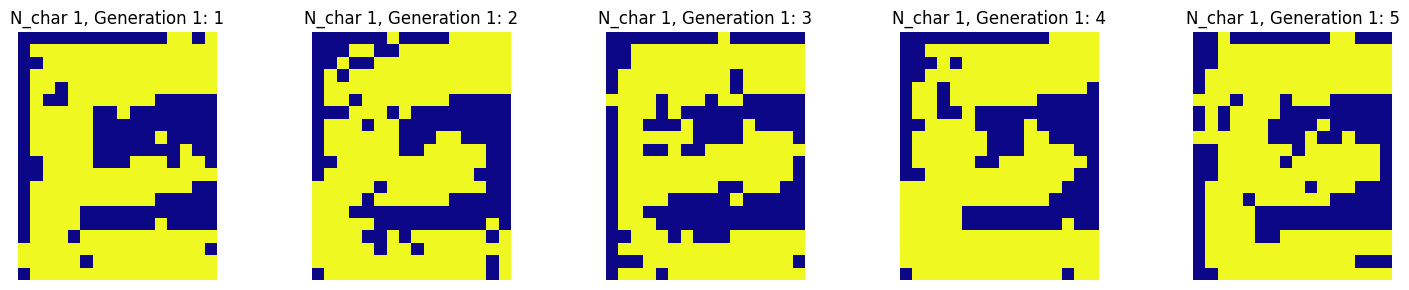


Training RBM with 200 hidden units on characters E


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 312.41it/s]


Reconstruction error: 0.20001.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 440.21it/s]



Training RBM with 200 hidden units on characters Y


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 336.94it/s]


Reconstruction error: 0.17934.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 751.71it/s]


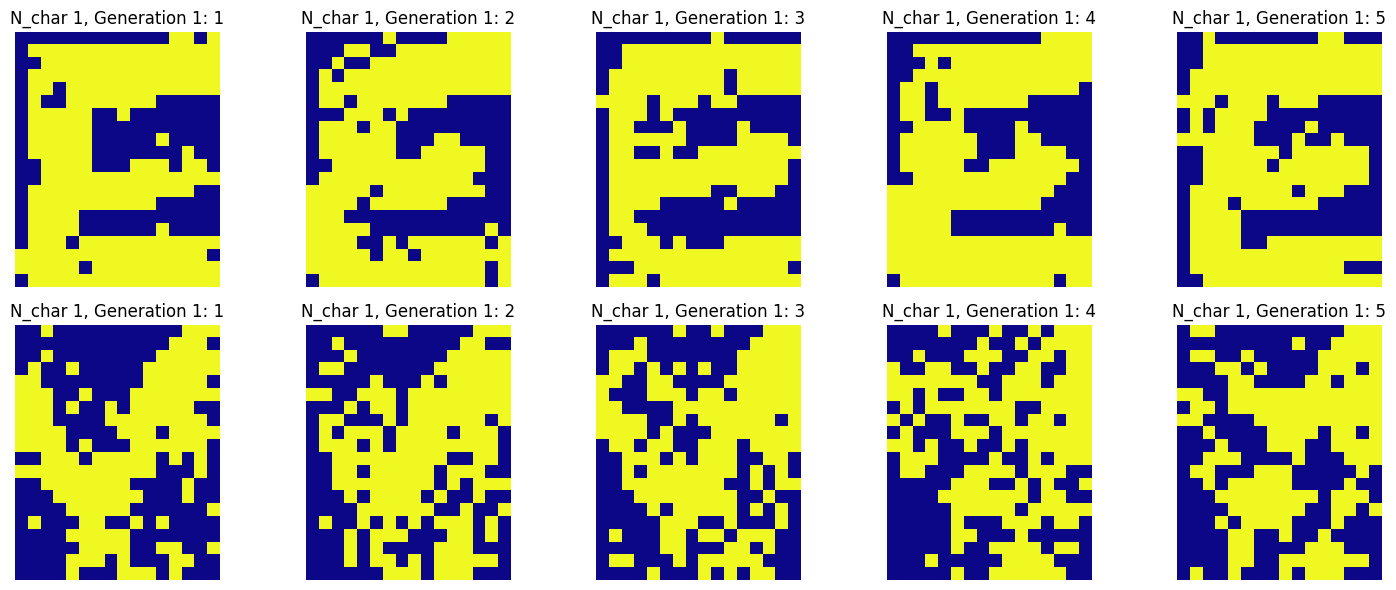


Training RBM with 200 hidden units on characters E


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 372.20it/s]


Reconstruction error: 0.20001.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 499.72it/s]



Training RBM with 200 hidden units on characters Y


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 681.19it/s]


Reconstruction error: 0.17934.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 598.99it/s]



Training RBM with 200 hidden units on characters 2


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 599.02it/s]


Reconstruction error: 0.19603.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 423.65it/s]


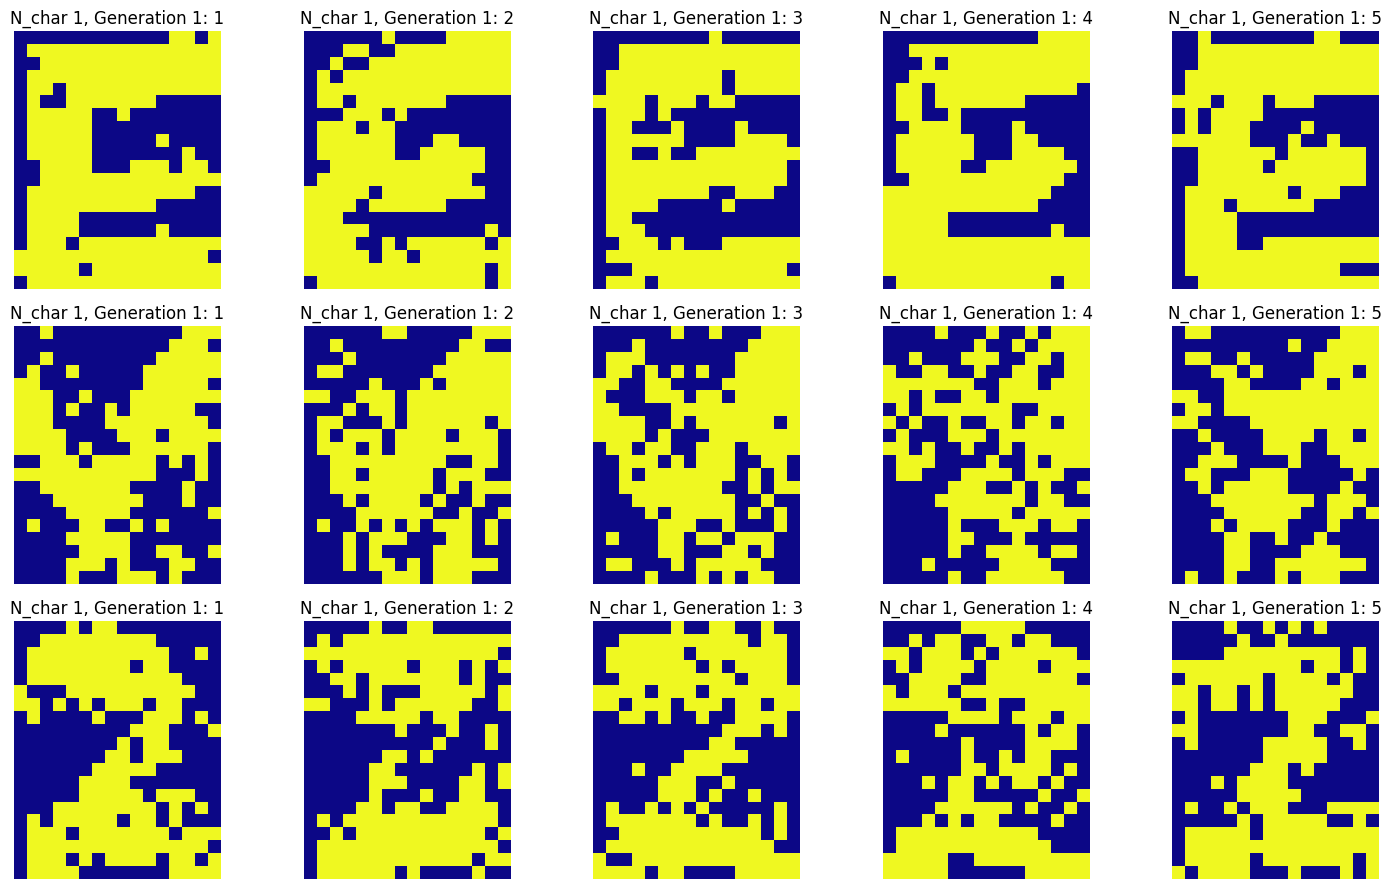


Training RBM with 200 hidden units on characters E


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 386.18it/s]


Reconstruction error: 0.20001.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 489.06it/s]



Training RBM with 200 hidden units on characters Y


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 477.24it/s]


Reconstruction error: 0.17934.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 520.32it/s]



Training RBM with 200 hidden units on characters A


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 600.47it/s]


Reconstruction error: 0.22527.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 544.15it/s]



Training RBM with 200 hidden units on characters 2


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 463.31it/s]


Reconstruction error: 0.19603.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 238.97it/s]


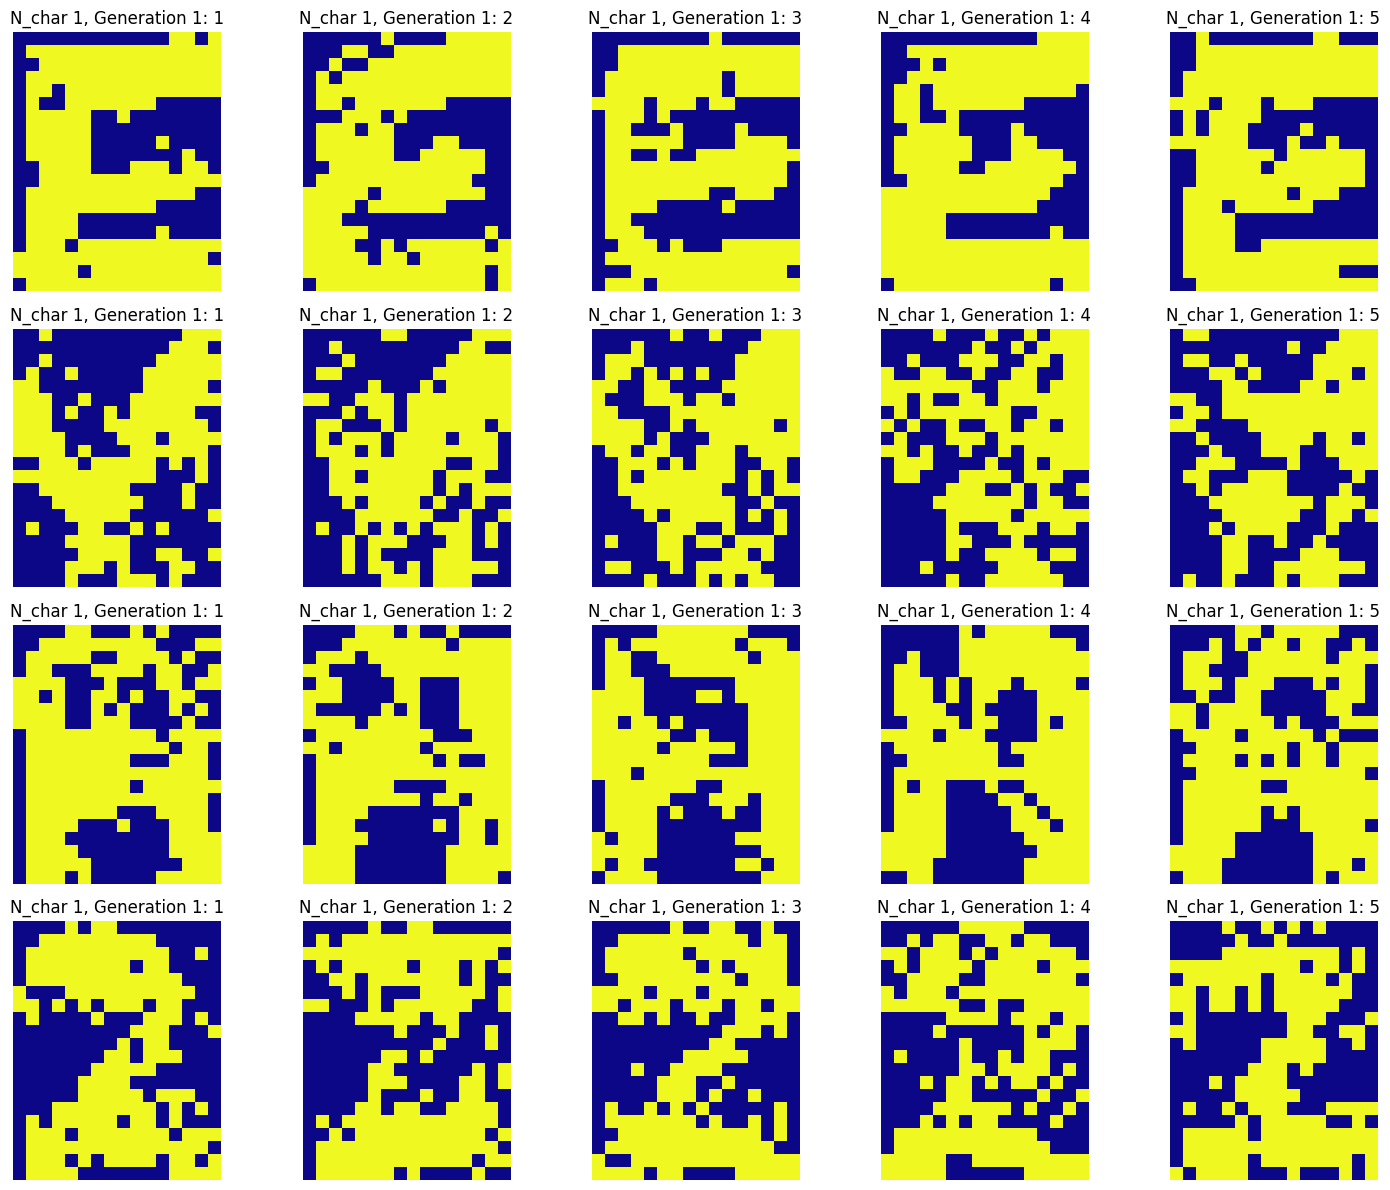


Training RBM with 200 hidden units on characters E


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 260.24it/s]


Reconstruction error: 0.20001.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 399.41it/s]



Training RBM with 200 hidden units on characters Y


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 664.74it/s]


Reconstruction error: 0.17934.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 499.72it/s]



Training RBM with 200 hidden units on characters A


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 428.50it/s]


Reconstruction error: 0.22527.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 397.24it/s]



Training RBM with 200 hidden units on characters 2


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 646.94it/s]


Reconstruction error: 0.19603.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 401.68it/s]



Training RBM with 200 hidden units on characters 7


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 458.49it/s]


Reconstruction error: 0.1376.


Epoch 499: 100%|██████████| 3/3 [00:00<00:00, 503.40it/s]


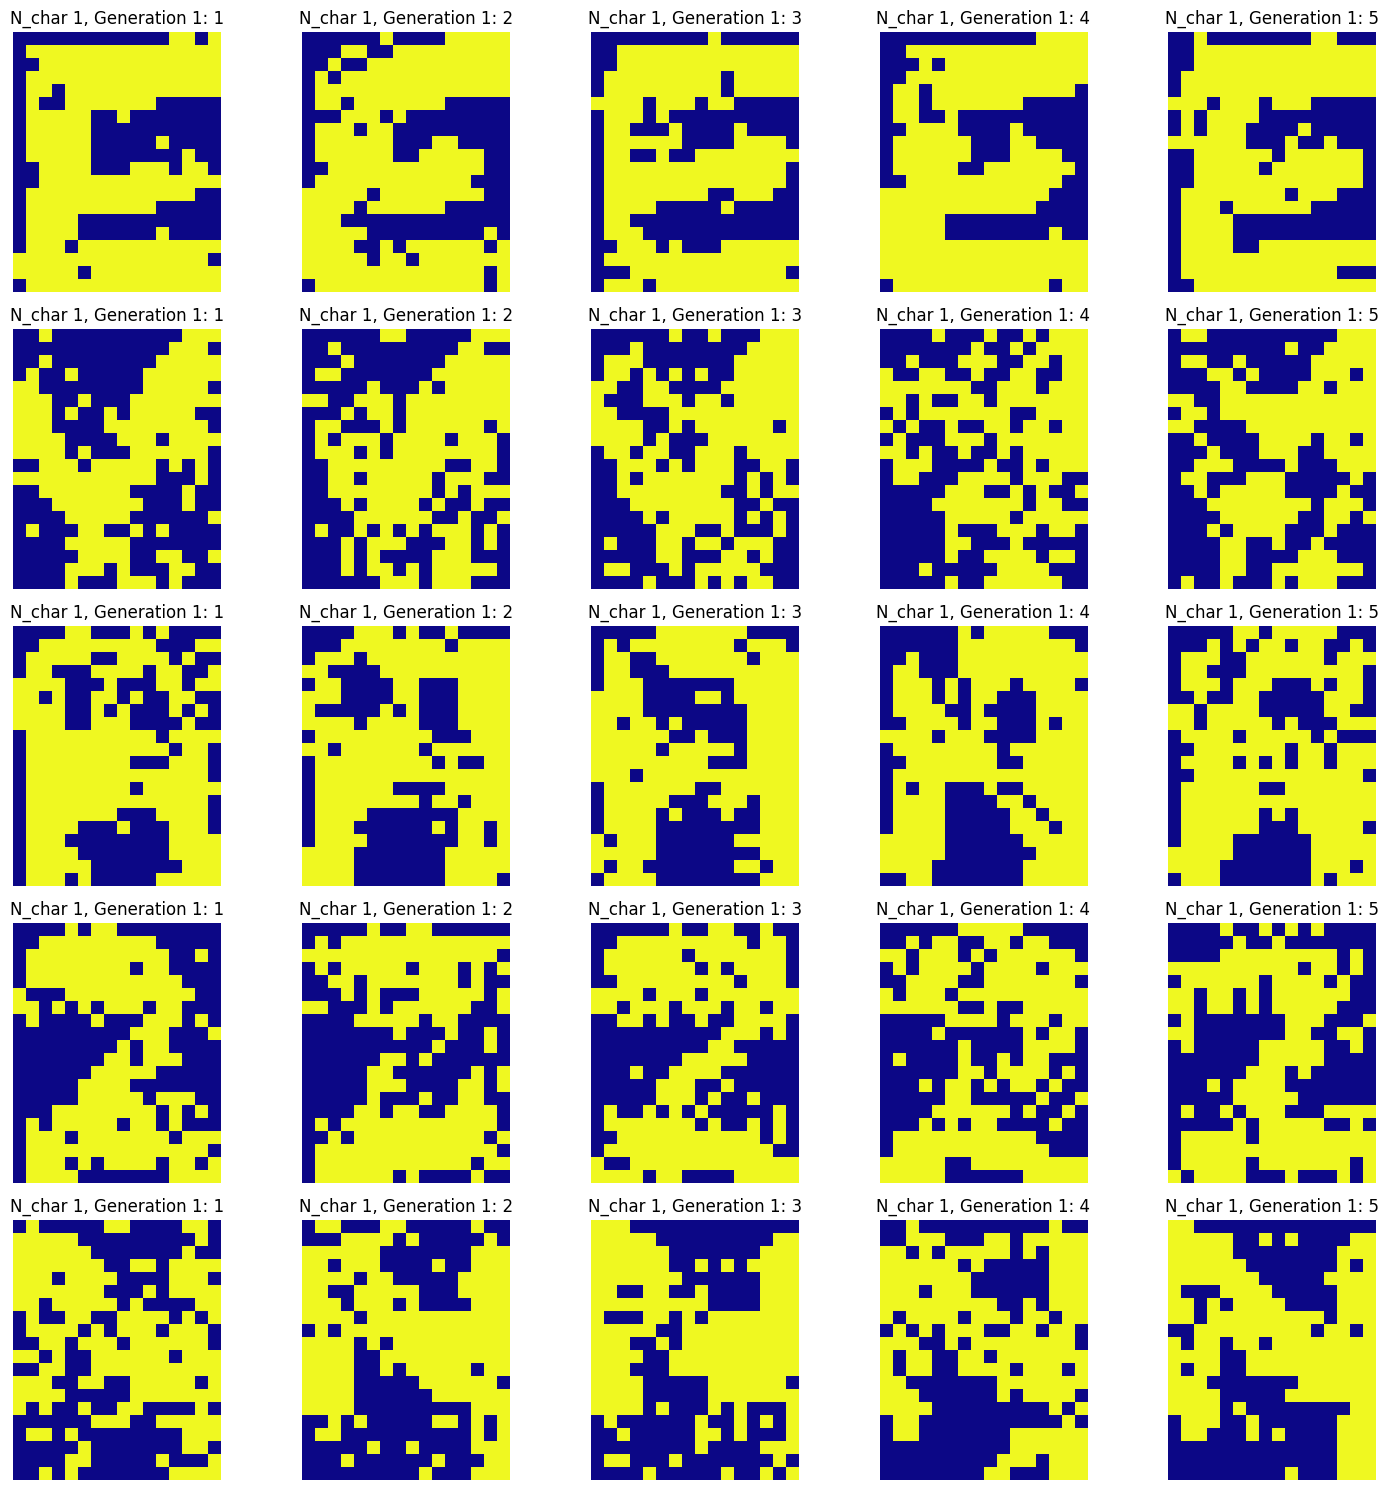

In [12]:
# configuration = 2 layer with 200 units each
configurations_fixe = [200]
run_rbm_experiment(configurations_fixe, n_epochs=500, character_sets = ['E'])
run_rbm_experiment(configurations_fixe, n_epochs=500, character_sets = ['E', 'Y'])
run_rbm_experiment(configurations_fixe, n_epochs=500, character_sets = ['E', 'Y', '2'])
run_rbm_experiment(configurations_fixe, n_epochs=500, character_sets = ['E', 'Y', 'A', '2'])
run_rbm_experiment(configurations_fixe, n_epochs=500, character_sets=['E', 'Y', 'A', '2', '7'])

In [ ]:
# Exemple d'utilisation
hidden_units_sizes = [100, 200, 300, 400, 500, 600, 700]
run_rbm_experiment(hidden_units_sizes, n_epochs=2, character_sets=[['A', 'B'], ['A', 'B', 'C'], ['A', 'B', 'C', 'D']])


### 2. DBM

In [ ]:
import matplotlib.pyplot as plt

def run_dbm_experiment(hidden_layers_sizes, n_epochs=100, characters=['A', 'B', '1', '2']):
    data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

    # Déterminer le nombre maximum de couches et le nombre unique d'unités
    max_layers = max(len(sizes) for sizes in hidden_layers_sizes)
    unique_units = sorted({sizes[0] for sizes in hidden_layers_sizes})

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(unique_units), max_layers, figsize=(max_layers * 3, len(unique_units) * 3), squeeze=False)

    # Initialiser tous les axes comme invisibles; ils seront activés lorsqu'utilisés
    for ax_row in axes:
        for ax in ax_row:
            ax.set_visible(False)

    for layer_sizes in hidden_layers_sizes:
        print(f"\nTraining DBN with hidden layers: {layer_sizes}")
        dbn = DBN(n_visible=data.shape[1], hidden_layer_sizes=layer_sizes, random_state=42)
        dbn.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=16, print_each=1000000)

        # Génération et affichage d'une image
        generated_image = dbn.generate_image(n_samples=5)
        unit_idx = unique_units.index(layer_sizes[0])
        layer_idx = len(layer_sizes) - 2  # Index 0 pour 2 couches, index 1 pour 3 couches, etc.

        ax = axes[unit_idx][layer_idx]
        ax.set_visible(True)
        ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
        ax.set_title(f"N_Layers: {len(layer_sizes)}, N_Units: {layer_sizes[0]}, N_Chars: {len(characters)}")
        ax.axis('off')

        # Enregistrement de l'image générée
        directory = f"../resultat/dbn/{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers"
        os.makedirs(directory, exist_ok=True)
        np.save(f"{directory}/Units_{layer_sizes[0]}_Chars_{''.join(characters)}.npy", generated_image[0])

    #save figure
    plt.tight_layout()
    directory_image = "../resultat/images/dbn"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/dbn_{len(characters)}_chars_{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers.png")
    plt.tight_layout()
    plt.show()



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=2, characters=['Y'])


In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=1000, characters=['Y', 'A'])



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=1000, characters=['Y', 'U', 'Z'])



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=1000, characters=['Y', 'A', 'B', '1'])



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_dbm_experiment(configurations, n_epochs=1000, characters=['Y', 'A', 'B', '1', '2'])



# read saved files for RBM and DBM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_and_display_image(file_path):
    """
    Charge et affiche une image à partir d'un fichier .npy.
    
    Args:
    file_path (str): Le chemin du fichier .npy à charger.
    """
    # Charger l'image à partir du fichier .npy
    image = np.load(file_path)
    
    image_data_reshaped = image.reshape((20, 16))

    # Afficher l'image
    plt.imshow(image_data_reshaped, cmap='plasma') # ou 'gray ou 'viridis' ou 'inferno' ou 'plasma' ou 'magma' ou 'cividis')
    plt.title("Loaded Image")
    plt.axis('off')  # Désactiver les axes pour une meilleure visualisation
    plt.show()

# Exemple d'utilisation
file_path = "../resultat/dbn/100_Units_2_Layers/Units_100_Chars_A.npy"
load_and_display_image(file_path)

file_path2 = "../resultat/rbn/100_Units_2_Chars.npy"
load_and_display_image(file_path2)